In [14]:
!pip install imbalanced-learn xgboost



In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE

## 📥 Load Dataset

In [16]:
# Load and filter data
df = pd.read_csv("diabetes.csv")
df = df.drop(columns=["SkinThickness", "Insulin"])


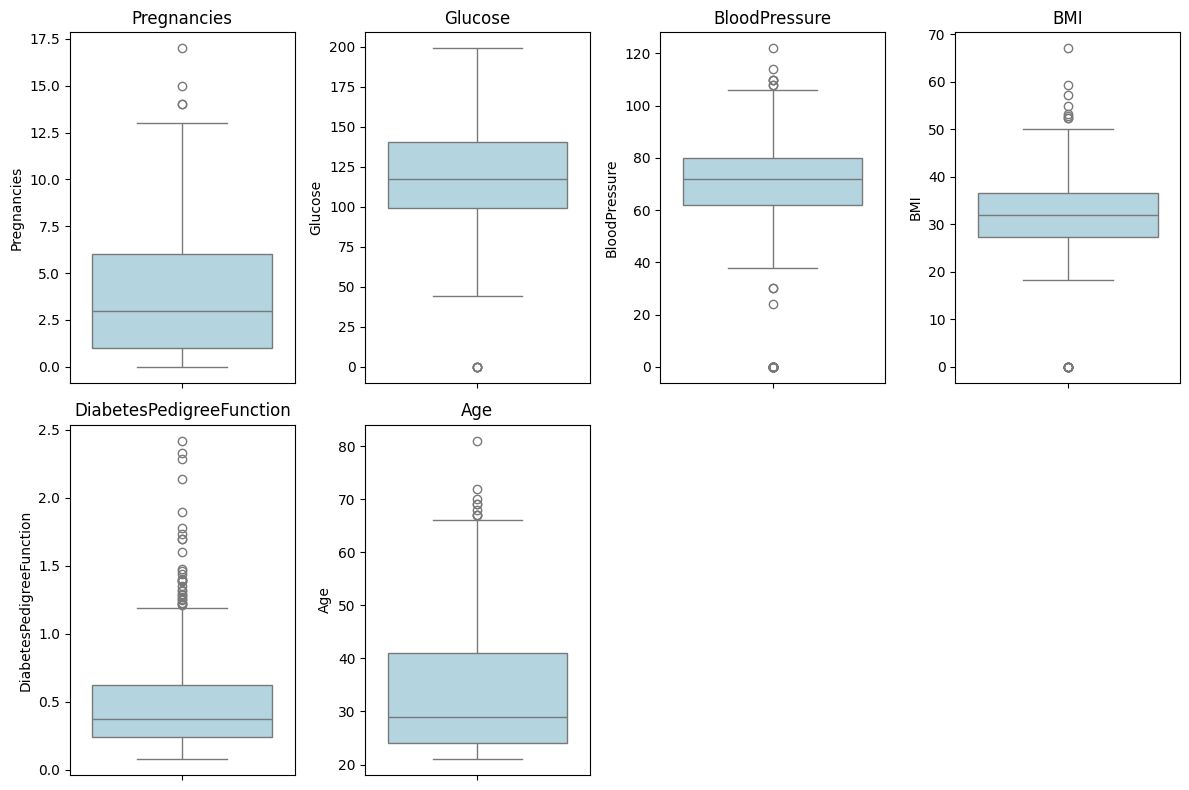

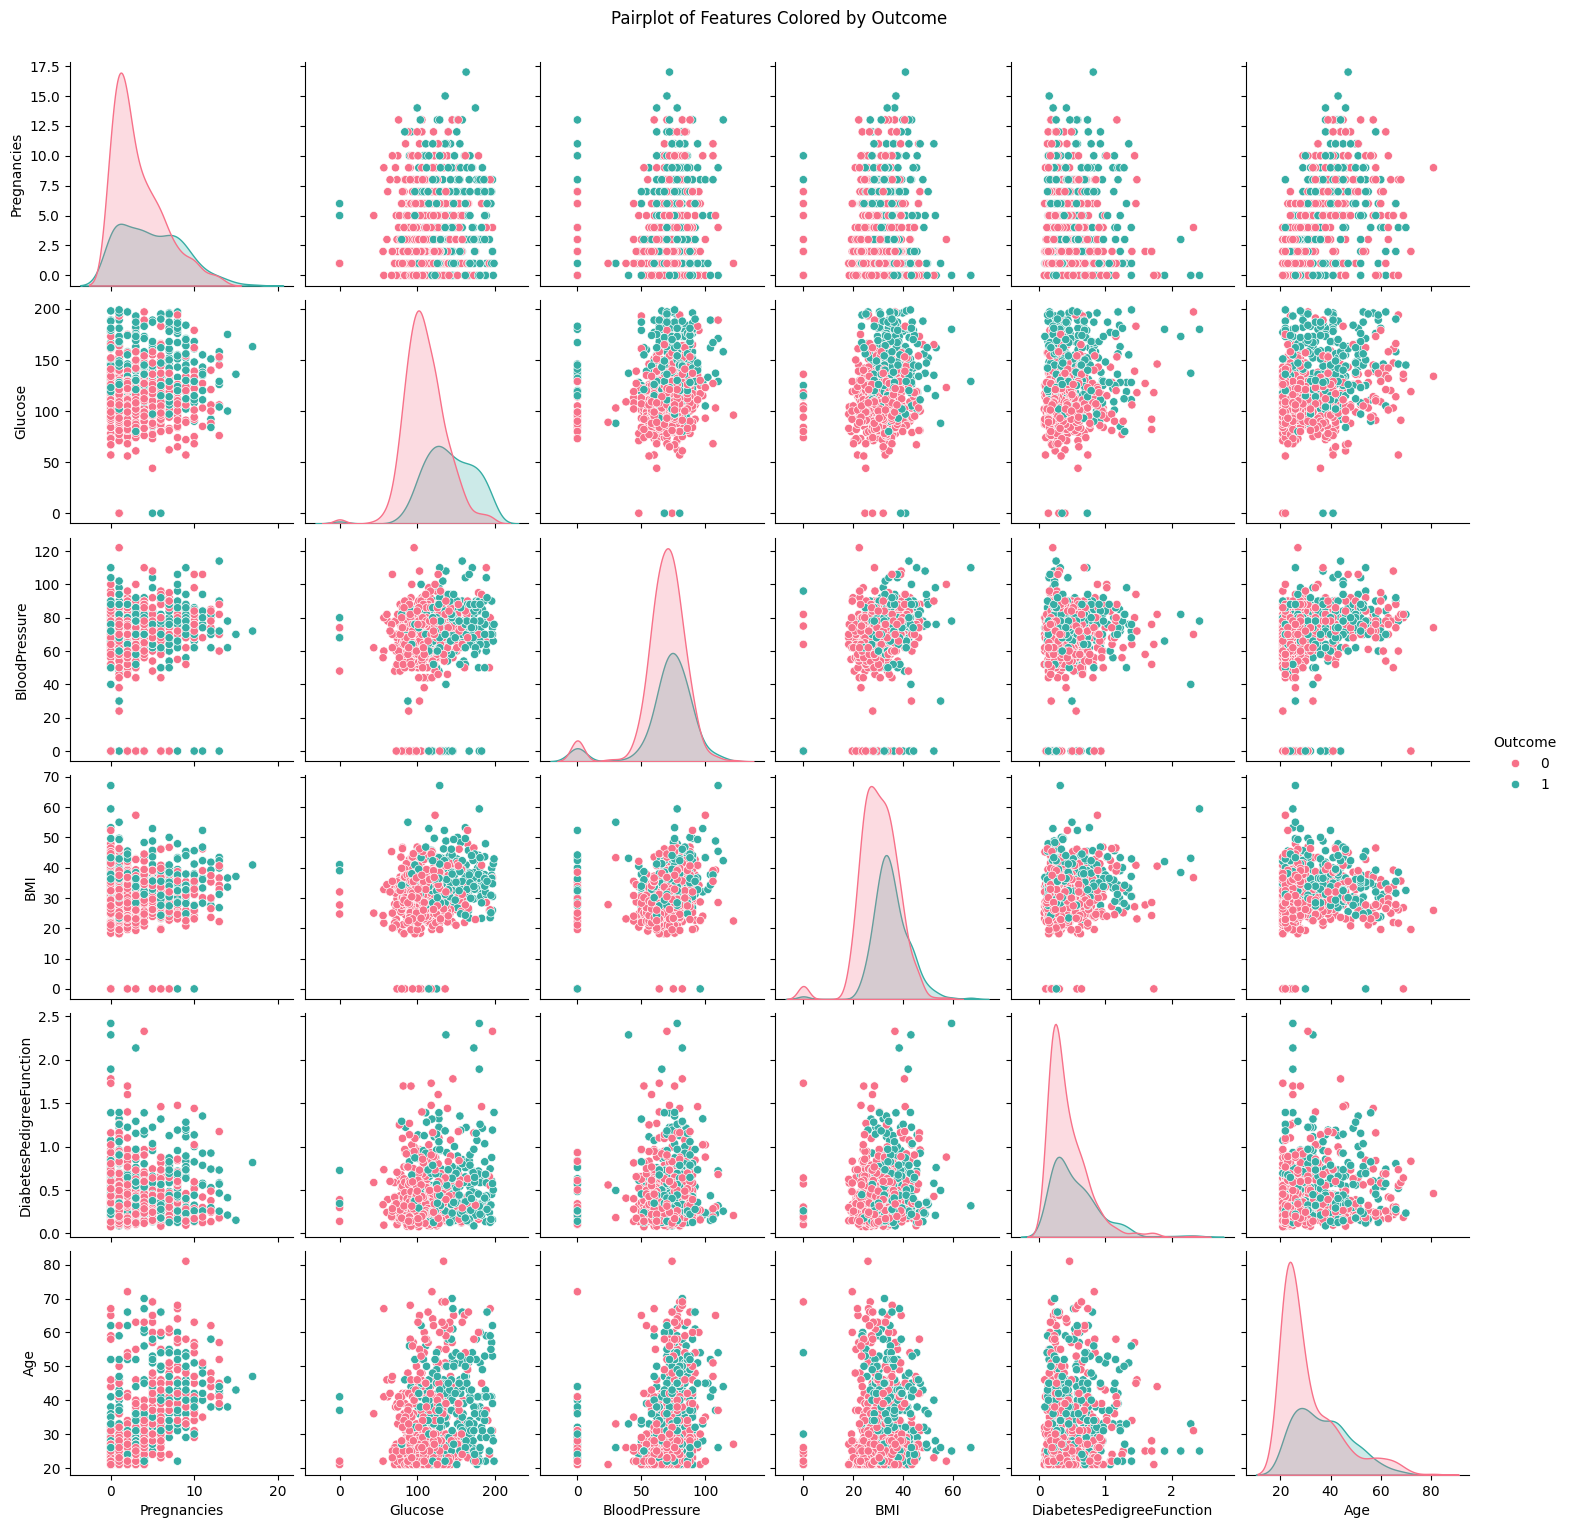

In [17]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=df[col], color="lightblue")
    plt.title(col)
plt.tight_layout()
plt.show()

sns.pairplot(df, hue="Outcome", diag_kind="kde", palette="husl")
plt.suptitle("Pairplot of Features Colored by Outcome", y=1.02)
plt.show()

In [18]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]



In [19]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

In [21]:
selector = RFECV(LogisticRegression(max_iter=1000), step=1, cv=5)
X_selected = selector.fit_transform(X_poly, y)


In [22]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [24]:
rf_params = {
    'n_estimators': [200, 300, 400],
    'max_depth': [8, 10, 12],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

In [25]:
xgb_params = {
    'n_estimators': [100, 150],
    'max_depth': [3, 4],
    'learning_rate': [0.05, 0.1]
}
xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgb_params, cv=3, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:11:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [26]:
voting = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', best_rf),
    ('xgb', best_xgb)
], voting='soft')

voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)
y_proba = voting.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:11:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8
Precision: 0.7850467289719626
Recall: 0.8316831683168316
F1 Score: 0.8076923076923077
AUC-ROC: 0.862086208620862


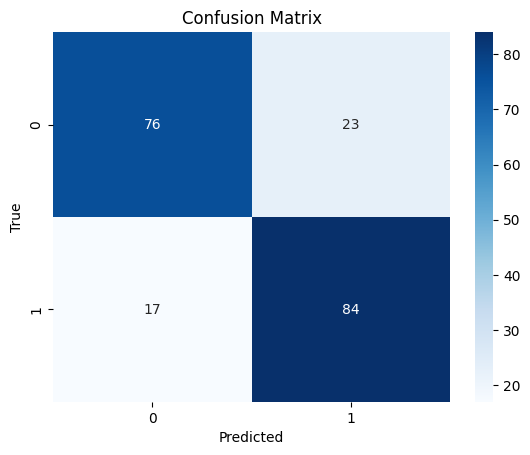

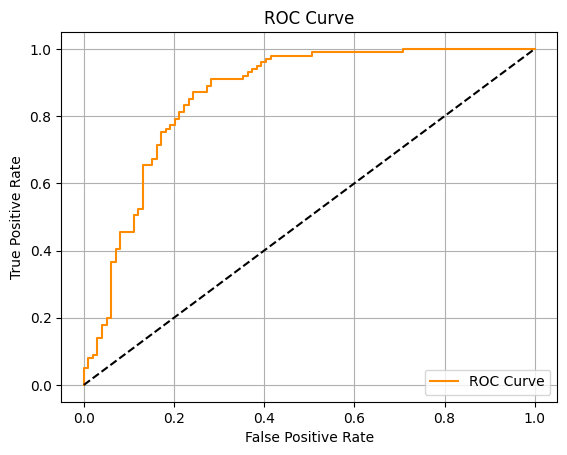

In [27]:
def evaluate_model(y_test, y_pred, y_proba):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_proba))

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label="ROC Curve", color='darkorange')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

evaluate_model(y_test, y_pred, y_proba)

In [29]:
import joblib
filename = 'diabetes.sav'
joblib.dump(voting, filename)

['diabetes.sav']